In [ ]:
import pandas as pd

In [56]:
import re
import pandas as pd
from pathlib import Path

log_dir = Path.cwd()

line_pattern = re.compile(
    r"Average steps/s:\s+([\d.]+)\s+\|\s+Average tokens/s:\s+([\d.]+)\s+\|\s+Average TFLOPS:\s+([\d.]+)",
    re.IGNORECASE
)

file_pattern = re.compile(
    r"(.+?)_(.+?)_(\d+B)_(\d+)_(bf16|fp8)_(\d+)gpus\.txt", re.IGNORECASE
)

records = []

for file in log_dir.glob("*.txt"):
    fname = file.name
    match = file_pattern.match(fname)
    if not match:
        print("❌ Filename didn't match:", fname)
        continue

    org, model, size, seq_len, precision, num_gpus = match.groups()
    model_name = f"{org}_{model}_{size}"

    steps_s, tokens_s, tflops = [], [], []
    with open(file, "r") as f:
        for line in f:
            m = line_pattern.search(line)
            if m:
                steps_s.append(float(m.group(1)))
                tokens_s.append(float(m.group(2)))
                tflops.append(float(m.group(3)))

    if steps_s:
        avg_steps = sum(steps_s) / len(steps_s)
        avg_tokens = sum(tokens_s) / len(tokens_s)
        avg_tflops = sum(tflops) / len(tflops)
        time_per_step = 1.0 / avg_steps if avg_steps > 0 else None

        records.append({
            "Model": model_name,
            "Seq Len": int(seq_len),
            "Precision": precision.upper(),
            "GPUs": int(num_gpus),
            "Avg Tokens/s": avg_tokens,
            "Avg TFLOPs": avg_tflops,
            "Time per Step (s)": time_per_step
        })

df = pd.DataFrame(records)


In [57]:
df.head()

,Model,Seq Len,Precision,GPUs,Avg Tokens/s,Avg TFLOPs,Time per Step (s)
0,meta_llama_Llama_3.2_1B,8192,FP8,4,8054.450,64.868,1.018330
1,Qwen_Qwen3_4B,4096,FP8,4,1459.778,30.170,2.777778
2,meta_llama_Llama_3.2_1B,2048,BF16,4,1698.988,9.578,1.204819
3,meta_llama_Llama_3.2_3B,4096,FP8,1,3671.352,62.092,1.116071
4,Qwen_Qwen3_4B,2048,FP8,2,2902.094,53.412,0.706215


In [38]:
df.to_csv("full_data.csv")

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("full_data.csv")

In [3]:
df.head()

,Unnamed: 0,Model,Seq Len,Precision,GPUs,Avg Tokens/s,Avg TFLOPs,Time per Step (s)
0,0,meta_llama_Llama_3.2_1B,8192,FP8,4,8054.450,64.868,1.018330
1,1,Qwen_Qwen3_4B,4096,FP8,4,1459.778,30.170,2.777778
2,2,meta_llama_Llama_3.2_1B,2048,BF16,4,1698.988,9.578,1.204819
3,3,meta_llama_Llama_3.2_3B,4096,FP8,1,3671.352,62.092,1.116071
4,4,Qwen_Qwen3_4B,2048,FP8,2,2902.094,53.412,0.706215


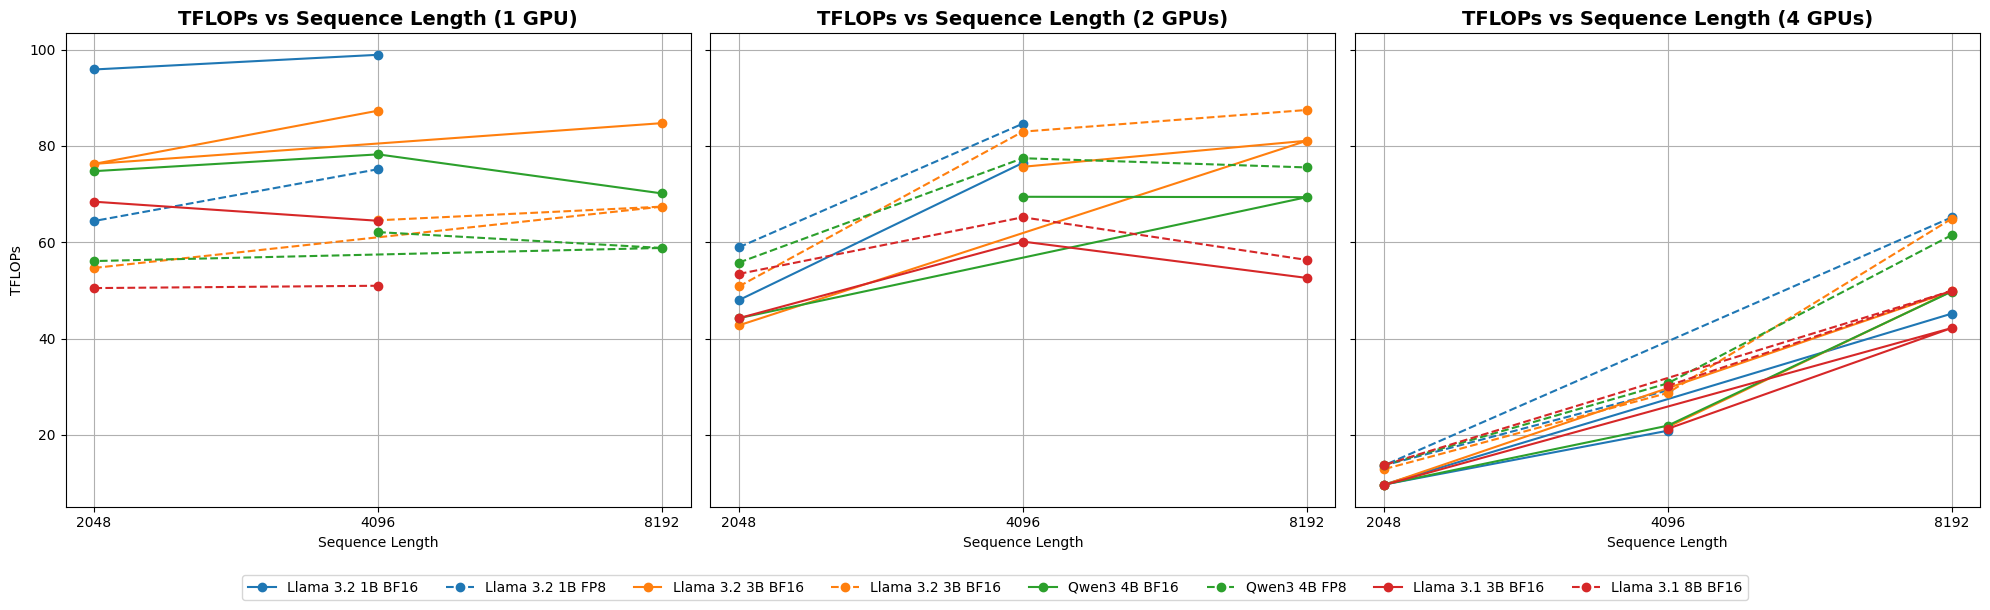

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Clean up model names (optional, for nicer labels)
df["Model"] = df["Model"].str.replace("meta_llama_", "", regex=False)
df["Model"] = df["Model"].str.replace("Qwen_", "", regex=False)
df["Model"] = df["Model"].str.replace("_", " ", regex=False)

# Ensure numeric columns
df["Seq Len"] = pd.to_numeric(df["Seq Len"], errors="coerce")
df["Avg TFLOPs"] = pd.to_numeric(df["Avg TFLOPs"], errors="coerce")

# ---------- Plot ----------
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
colors = plt.cm.tab10.colors

for ax, gpus in zip(axes, [1, 2, 4]):
    subset = df[df["GPUs"] == gpus]
    for idx, (model, group) in enumerate(subset.groupby("Model")):
        color = colors[idx % len(colors)]
        bf16 = group[group["Precision"] == "BF16"]
        fp8 = group[group["Precision"] == "FP8"]

        ax.plot(bf16["Seq Len"], bf16["Avg TFLOPs"], marker="o",
                linestyle="-", color=color, label=f"{model} BF16")
        ax.plot(fp8["Seq Len"], fp8["Avg TFLOPs"], marker="o",
                linestyle="--", color=color, label=f"{model} FP8")
    ax.set_title(f"TFLOPs vs Sequence Length ({gpus} GPU{'s' if gpus>1 else ''})",
                 fontsize=14, weight="bold")
    ax.set_xlabel("Sequence Length")
    ax.grid(True)
    ax.set_xscale("log", base=2)
    ax.set_xticks([2048, 4096, 8192])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # show numbers nicely


axes[0].set_ylabel("TFLOPs")

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Llama 3.2 1B BF16", "Llama 3.2 1B FP8", "Llama 3.2 3B BF16", "Llama 3.2 3B BF16", "Qwen3 4B BF16", "Qwen3 4B FP8",  "Llama 3.1 3B BF16", "Llama 3.1 8B BF16"]
fig.legend(handles, labels, loc="lower center",
           ncol=2 * len(df["Model"].unique()), bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


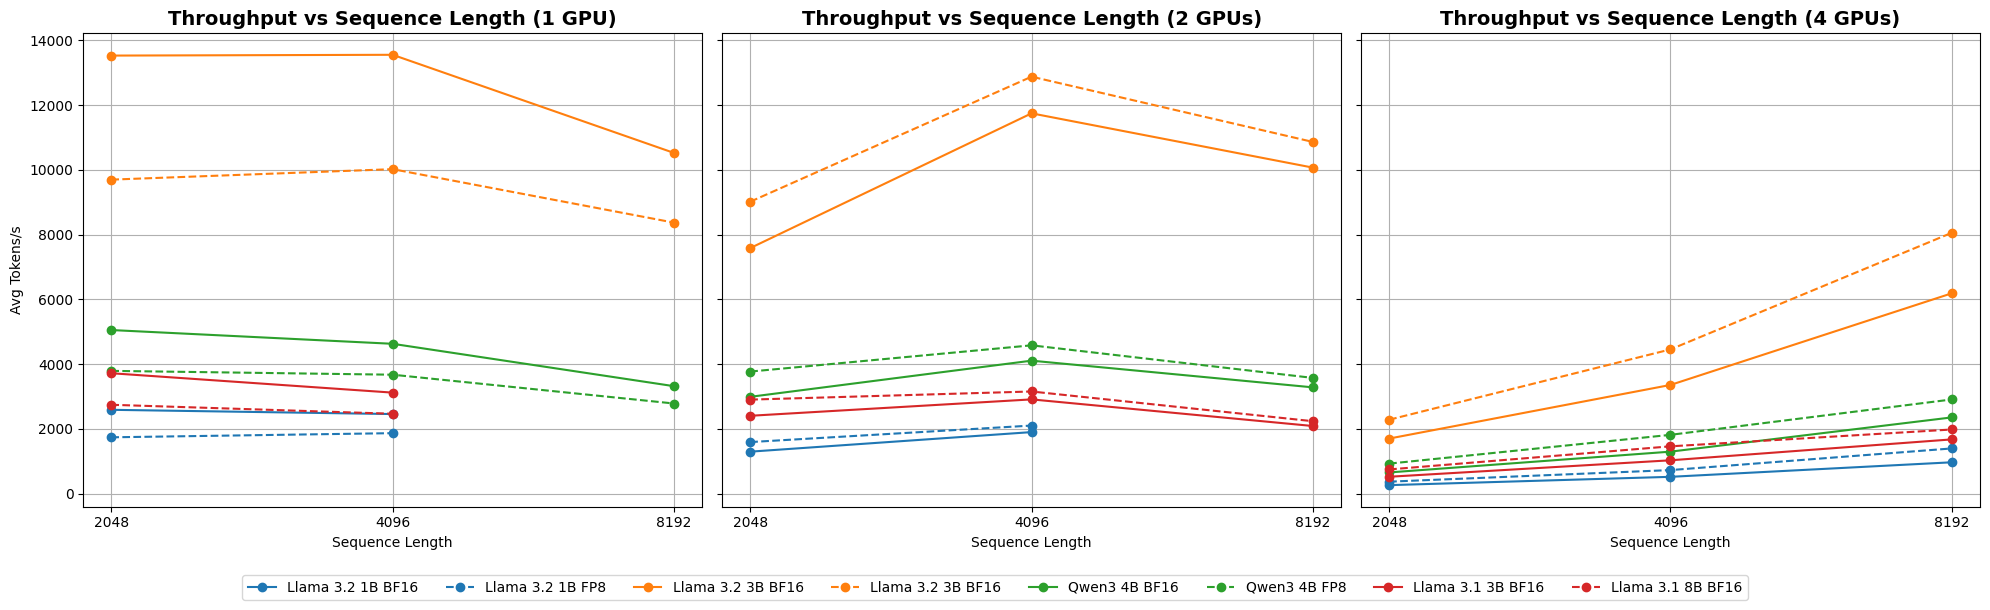

In [6]:

# Ensure numeric columns
df["Seq Len"] = pd.to_numeric(df["Seq Len"], errors="coerce")
df["Avg Tokens/s"] = pd.to_numeric(df["Avg Tokens/s"], errors="coerce")

# --- Aggregate to remove duplicates ---
df = df.groupby(["Model", "GPUs", "Seq Len", "Precision"], as_index=False)["Avg Tokens/s"].mean()

# ---------- Plot ----------
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
colors = plt.cm.tab10.colors

for ax, gpus in zip(axes, [1, 2, 4]):
    subset = df[df["GPUs"] == gpus]
    for idx, (model, group) in enumerate(subset.groupby("Model")):
        color = colors[idx % len(colors)]
        group = group.sort_values("Seq Len")  # enforce ordering
        bf16 = group[group["Precision"] == "BF16"]
        fp8 = group[group["Precision"] == "FP8"]

        ax.plot(bf16["Seq Len"], bf16["Avg Tokens/s"], marker="o",
                linestyle="-", color=color, label=f"{model} BF16")
        ax.plot(fp8["Seq Len"], fp8["Avg Tokens/s"], marker="o",
                linestyle="--", color=color, label=f"{model} FP8")

    ax.set_title(f"Throughput vs Sequence Length ({gpus} GPU{'s' if gpus>1 else ''})",
                 fontsize=14, weight="bold")
    ax.set_xlabel("Sequence Length")
    ax.set_xscale("log", base=2)
    ax.set_xticks([2048, 4096, 8192])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.grid(True)

axes[0].set_ylabel("Avg Tokens/s")

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Llama 3.2 1B BF16", "Llama 3.2 1B FP8", "Llama 3.2 3B BF16", "Llama 3.2 3B BF16", "Qwen3 4B BF16", "Qwen3 4B FP8",  "Llama 3.1 3B BF16", "Llama 3.1 8B BF16"]
fig.legend(handles, labels, loc="lower center",
           ncol=2 * len(df["Model"].unique()), bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

/tmp/ipykernel_251770/3501161118.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for idx, (model, group) in enumerate(data.groupby("Model", sort=False)):


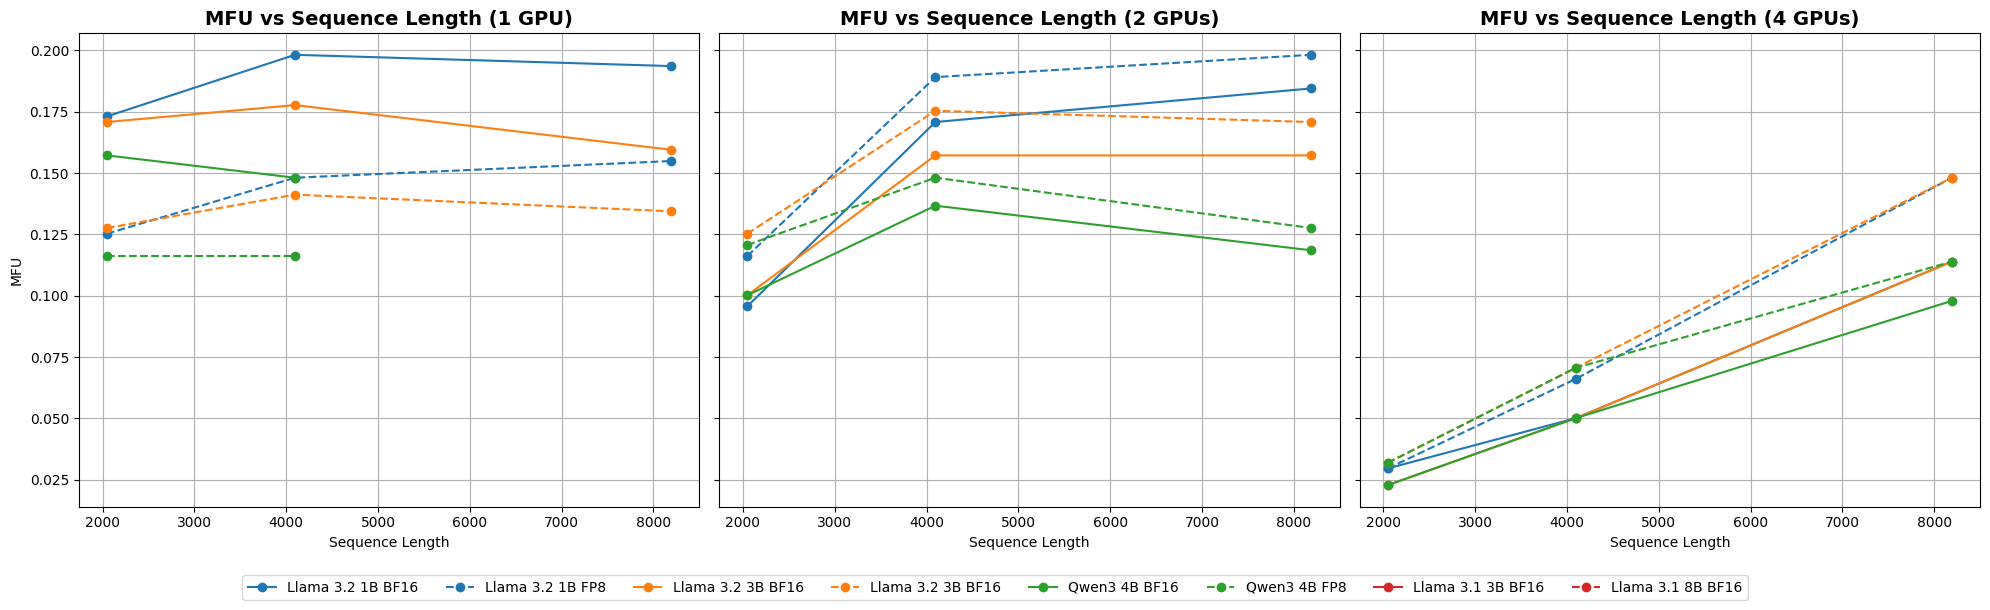

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Helper function to clean for TFLOPs ----------
def clean_tflops(path, col0="Unnamed: 0"):
    df = pd.read_csv(path)
    if col0 not in df.columns:
        col0 = df.columns[0]
    df["Model"] = df[col0].ffill()
    df = df[df["Model"] != "Model"]
    df = df[["Model", "Unnamed: 1", "MFU", "Unnamed: 5"]]
    df.columns = ["Model", "seq_len", "MFU BF16", "MFU FP8"]

    df["seq_len"] = pd.to_numeric(df["seq_len"], errors="coerce")
    df["MFU BF16"] = pd.to_numeric(df["MFU BF16"].str.replace('%', '', regex=True), errors="coerce") / 100
    df["MFU FP8"] = pd.to_numeric(df["MFU FP8"].str.replace('%', '', regex=True), errors="coerce") / 100

    # enforce model ordering
    model_order = ["Llama 3.2 1B", "Llama 3.2 3B", "Qwen3 4B", "Llama 3.1 8B"]
    df["Model"] = pd.Categorical(df["Model"], categories=model_order, ordered=True)
    return df.sort_values(["Model", "seq_len"])

# ---------- Load TFLOPs data ----------
df1_tf = clean_tflops("FP8 Experiments - gbs==32.csv")  # 1 GPU
df2_tf = clean_tflops("fp8_2_gpu.csv")                  # 2 GPUs
df4_tf = clean_tflops("fp8_4_gpu.csv", col0="mbs==1")   # 4 GPUs

# ---------- Plot ----------
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

datasets = [(df1_tf, "1 GPU"), (df2_tf, "2 GPUs"), (df4_tf, "4 GPUs")]
colors = plt.cm.tab10.colors

for ax, (data, title) in zip(axes, datasets):
    for idx, (model, group) in enumerate(data.groupby("Model", sort=False)):
        color = colors[idx % len(colors)]
        ax.plot(group["seq_len"], group["MFU BF16"], marker="o",
                linestyle="-", color=color, label=f"{model} BF16")
        ax.plot(group["seq_len"], group["MFU FP8"], marker="o",
                linestyle="--", color=color, label=f"{model} FP8")
    ax.set_title(f"MFU vs Sequence Length ({title})", fontsize=14, weight="bold")
    ax.set_xlabel("Sequence Length")
    ax.grid(True)

axes[0].set_ylabel("MFU")

# Shared legend below all panels
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Llama 3.2 1B BF16", "Llama 3.2 1B FP8", "Llama 3.2 3B BF16", "Llama 3.2 3B BF16", "Qwen3 4B BF16", "Qwen3 4B FP8",  "Llama 3.1 3B BF16", "Llama 3.1 8B BF16"]
fig.legend(handles, labels, loc="lower center",
           ncol=2 * len(df1_tf["Model"].unique()), bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


/tmp/ipykernel_251770/40476796.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for idx, (model, group) in enumerate(data.groupby("Model", sort=False)):


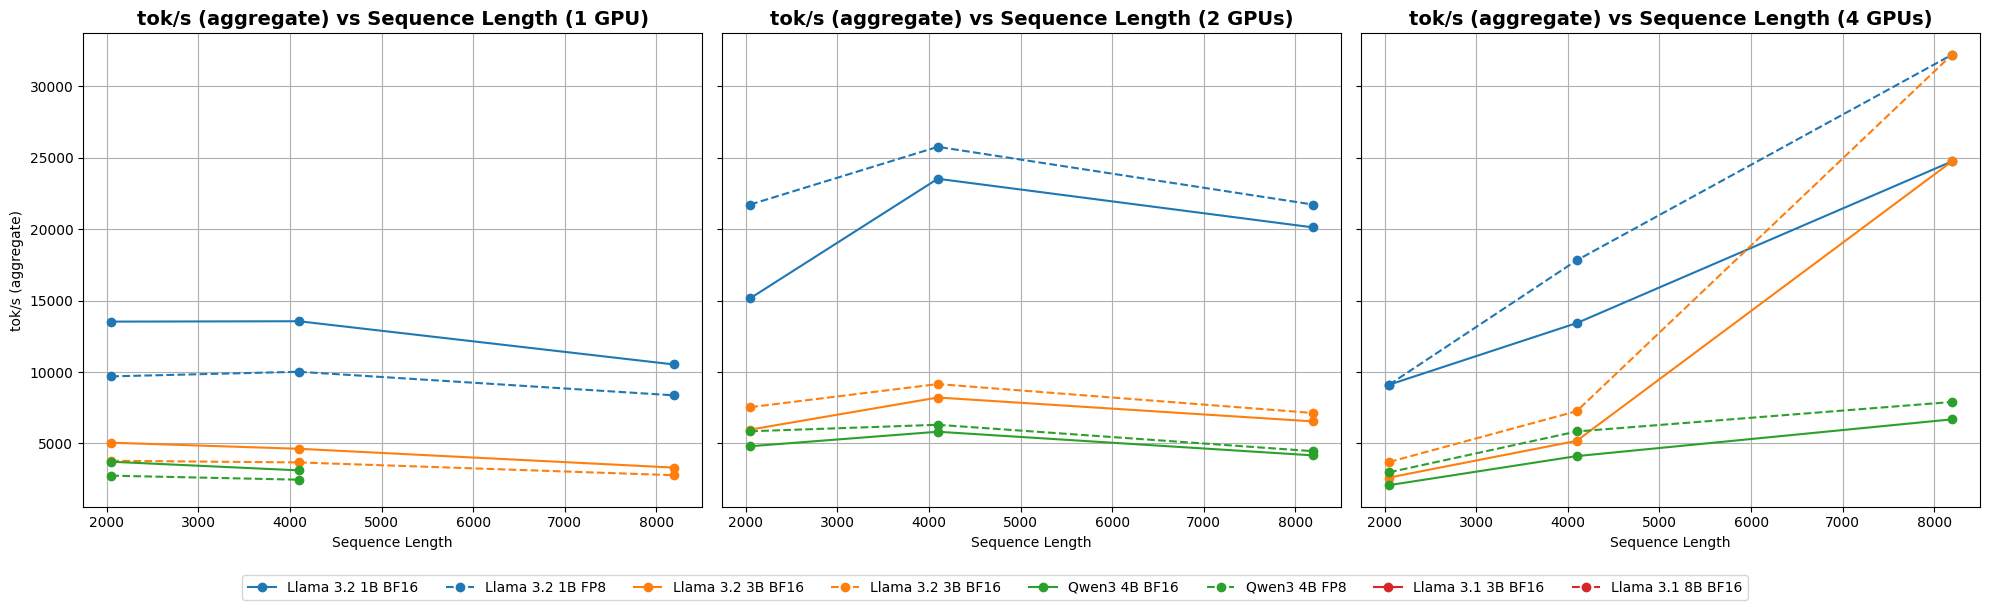

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Helper function to clean for TFLOPs ----------
def clean_tflops(path, col0="Unnamed: 0"):
    df = pd.read_csv(path)
    if col0 not in df.columns:
        col0 = df.columns[0]
    df["Model"] = df[col0].ffill()
    df = df[df["Model"] != "Model"]
    df = df[["Model", "Unnamed: 1", "tok/s (aggregate)", "Unnamed: 7"]]
    df.columns = ["Model", "seq_len", "tok/s BF16", "tok/s FP8"]

    df["seq_len"] = pd.to_numeric(df["seq_len"], errors="coerce")
    df["tok/s BF16"] = pd.to_numeric(df["tok/s BF16"], errors="coerce")
    df["tok/s FP8"] = pd.to_numeric(df["tok/s FP8"], errors="coerce")

    # enforce model ordering
    model_order = ["Llama 3.2 1B", "Llama 3.2 3B", "Qwen3 4B", "Llama 3.1 8B"]
    df["Model"] = pd.Categorical(df["Model"], categories=model_order, ordered=True)
    return df.sort_values(["Model", "seq_len"])

# ---------- Load tok/s data ----------
df1_tf = clean_tflops("FP8 Experiments - gbs==32.csv")  # 1 GPU
df2_tf = clean_tflops("fp8_2_gpu.csv")                  # 2 GPUs
df4_tf = clean_tflops("fp8_4_gpu.csv", col0="mbs==1")   # 4 GPUs

# ---------- Plot ----------
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

datasets = [(df1_tf, "1 GPU"), (df2_tf, "2 GPUs"), (df4_tf, "4 GPUs")]
colors = plt.cm.tab10.colors

for ax, (data, title) in zip(axes, datasets):
    for idx, (model, group) in enumerate(data.groupby("Model", sort=False)):
        color = colors[idx % len(colors)]
        ax.plot(group["seq_len"], group["tok/s BF16"], marker="o",
                linestyle="-", color=color, label=f"{model} BF16")
        ax.plot(group["seq_len"], group["tok/s FP8"], marker="o",
                linestyle="--", color=color, label=f"{model} FP8")
    ax.set_title(f"tok/s (aggregate) vs Sequence Length ({title})", fontsize=14, weight="bold")
    ax.set_xlabel("Sequence Length")
    ax.grid(True)

axes[0].set_ylabel("tok/s (aggregate)")

# Shared legend below all panels
handles, labels = axes[0].get_legend_handles_labels()
labels = ["Llama 3.2 1B BF16", "Llama 3.2 1B FP8", "Llama 3.2 3B BF16", "Llama 3.2 3B BF16", "Qwen3 4B BF16", "Qwen3 4B FP8",  "Llama 3.1 3B BF16", "Llama 3.1 8B BF16"]
fig.legend(handles, labels, loc="lower center",
           ncol=2 * len(df1_tf["Model"].unique()), bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()
